In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("diminos_data.csv")

# Basic inspection
df.head()

,order_id,order_placed_at,order_delivered_at
0,1523111,2023-03-01 00:00:59,2023-03-01 00:18:07.443132
1,1523112,2023-03-01 00:03:59,2023-03-01 00:19:34.925241
2,1523113,2023-03-01 00:07:22,2023-03-01 00:22:28.291385
3,1523114,2023-03-01 00:07:47,2023-03-01 00:46:19.019399
4,1523115,2023-03-01 00:09:03,2023-03-01 00:25:13.619056


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   order_id            15000 non-null  int64 
 1   order_placed_at     15000 non-null  object
 2   order_delivered_at  15000 non-null  object
dtypes: int64(1), object(2)
memory usage: 351.7+ KB


In [6]:
df.isnull().sum()

order_id              0
order_placed_at       0
order_delivered_at    0
dtype: int64

In [8]:
df.describe()

,order_id
count,1.500000e+04
mean,1.530610e+06
std,4.330271e+03
min,1.523111e+06
25%,1.526861e+06
50%,1.530610e+06
75%,1.534360e+06
max,1.538110e+06


In [16]:
df.columns

Index(['order_id', 'order_placed_at', 'order_delivered_at'], dtype='object')

In [20]:
df['order_placed_at'] = pd.to_datetime(df['order_placed_at'])
df['order_delivered_at'] = pd.to_datetime(df['order_delivered_at'])

In [22]:
df['delivery_time_minutes'] = (
    df['order_delivered_at'] - df['order_placed_at']
).dt.total_seconds() / 60

In [24]:
df[['order_placed_at', 'order_delivered_at', 'delivery_time_minutes']].head()

,order_placed_at,order_delivered_at,delivery_time_minutes
0,2023-03-01 00:00:59,2023-03-01 00:18:07.443132,17.140719
1,2023-03-01 00:03:59,2023-03-01 00:19:34.925241,15.598754
2,2023-03-01 00:07:22,2023-03-01 00:22:28.291385,15.104856
3,2023-03-01 00:07:47,2023-03-01 00:46:19.019399,38.533657
4,2023-03-01 00:09:03,2023-03-01 00:25:13.619056,16.176984


In [26]:
df['delivery_time_minutes'].describe()

count    15000.000000
mean        20.499389
std         96.160362
min         15.000010
25%         15.274826
50%         15.797986
75%         17.279661
max       7299.831375
Name: delivery_time_minutes, dtype: float64

In [30]:
# Remove invalid values if any
df = df[df['delivery_time_minutes'] > 0]

In [32]:
# Remove extreme outliers:
df = df[df['delivery_time_minutes'] < 120]

In [34]:
# Key Metric: 95th Percentile Delivery Time
df['delivery_time_minutes'].dtype
np.percentile(df['delivery_time_minutes'], 95)

26.247372241666667

In [40]:
# Percentage of Late Deliveries (>31 mins)
late_orders = (df['delivery_time_minutes'] > 31).mean() * 100
late_orders

3.2683678253298507

In [42]:
# Count of Late Orders
late_count = (df['delivery_time_minutes'] > 31).sum()
total_orders = len(df)

late_count, total_orders

(488, 14931)

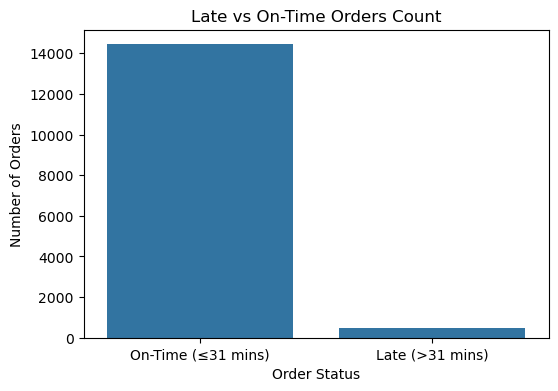

In [80]:
# Late vs On-Time Orders
df['Order_Status'] = np.where(
    df['delivery_time_minutes'] > 31,
    'Late (>31 mins)',
    'On-Time (≤31 mins)'
)

plt.figure(figsize=(6,4))
sns.countplot(x='Order_Status', data=df)
plt.xlabel("Order Status")
plt.ylabel("Number of Orders")
plt.title("Late vs On-Time Orders Count")
plt.show()

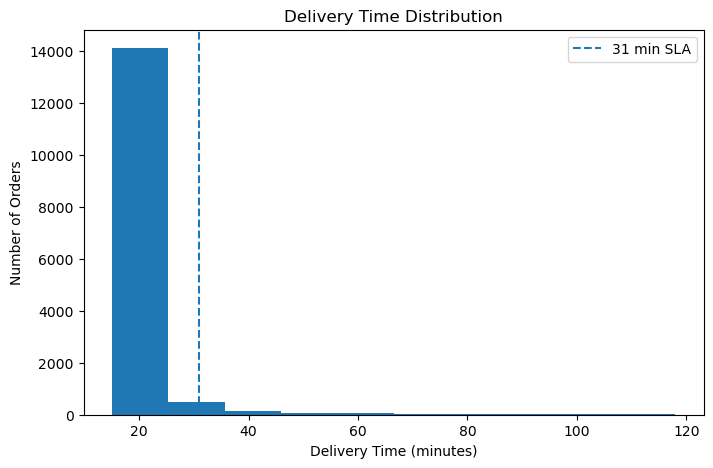

In [54]:
# Distribution of Delivery Times
plt.figure(figsize=(8,5))
plt.hist(df['delivery_time_minutes'], bins=10)
plt.axvline(31, linestyle='--', label='31 min SLA')
plt.xlabel("Delivery Time (minutes)")
plt.ylabel("Number of Orders")
plt.title("Delivery Time Distribution")
plt.legend()
plt.show()

In [82]:
# Calculate quartiles
Q1 = df['delivery_time_minutes'].quantile(0.25)
Q3 = df['delivery_time_minutes'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[
    (df['delivery_time_minutes'] < lower_bound) |
    (df['delivery_time_minutes'] > upper_bound)
]

# Count outliers
num_outliers = outliers.shape[0]

num_outliers

1692

In [84]:
outlier_percentage = (num_outliers / len(df)) * 100
outlier_percentage

11.33212778782399

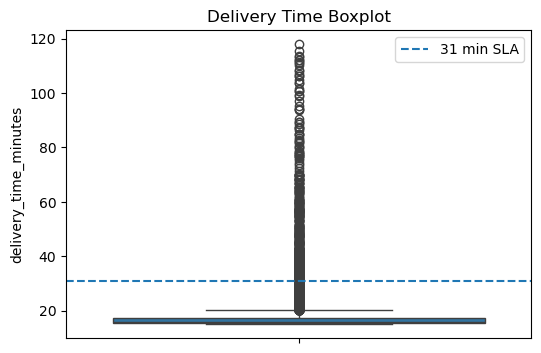

In [74]:
# Box Plot (Outlier Detection)
plt.figure(figsize=(6,4))
sns.boxplot(y=df['delivery_time_minutes'])
plt.axhline(31, linestyle='--', label='31 min SLA')
plt.title("Delivery Time Boxplot")
plt.legend()
plt.show()

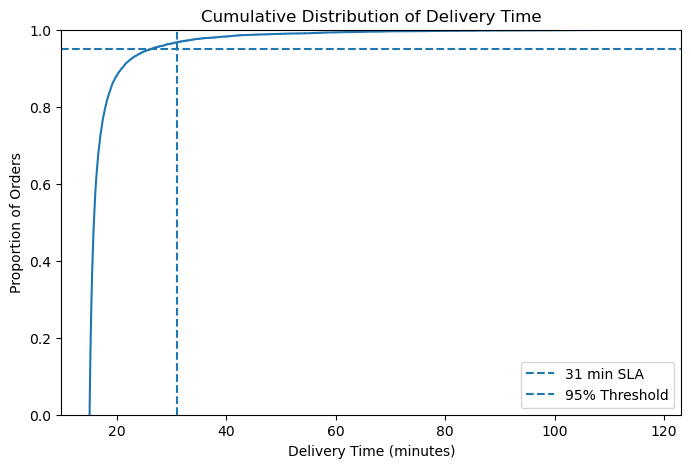

In [64]:
# Cumulative Distribution of Delivery Time
plt.figure(figsize=(8,5))
sns.ecdfplot(df['delivery_time_minutes'])
plt.axvline(31, linestyle='--', label='31 min SLA')
plt.axhline(0.95, linestyle='--', label='95% Threshold')
plt.xlabel("Delivery Time (minutes)")
plt.ylabel("Proportion of Orders")
plt.title("Cumulative Distribution of Delivery Time")
plt.legend()
plt.show()

In [66]:
# Peak vs Non-Peak Analysis
df['Order_Hour'] = pd.to_datetime(df['order_placed_at']).dt.hour

peak = df[df['Order_Hour'].between(18, 23)]
non_peak = df[~df['Order_Hour'].between(18, 23)]

np.percentile(peak['delivery_time_minutes'], 95), np.percentile(non_peak['delivery_time_minutes'], 95)

(25.658154246666662, 26.384017924166663)

## Key Insights 

* Majority of pizza orders are delivered within the 31-minute assured timeframe.

* Overall store operations are efficient and well-managed.

* Delivery time distribution is right-skewed, indicating a few very late deliveries.

* Late deliveries occur infrequently but have very high delivery times.

* These extreme delays significantly affect the 95th percentile delivery metric.

* The 95th percentile exceeds the 31-minute SLA limit.

* As a result, despite most customers being served on time, the store fails to meet Diminos’ SLA requirements.

* This puts Kanav’s franchise at potential operational and contractual risk.

## Key Recommendations 

* Focus on improving the slowest 5% of deliveries, not all orders.

* Reduce extreme delivery delays by identifying root causes.

* Increase delivery staff during peak demand hours.

* Improve kitchen preparation efficiency to reduce order wait time.

* Optimize delivery route planning to avoid traffic delays.

* Limit or control delivery radius during high-traffic periods.

* Implement real-time order monitoring and tracking.

* Track the daily 95th percentile delivery time to detect SLA risks early.

* Target lowering the 95th percentile below 31 minutes to meet SLA standards.

## **Conclusion:**
The analysis of delivery performance highlights that while the store performs well for the majority of orders, a small number of significantly delayed deliveries prevent compliance with Diminos’ service-level agreement. The failure to meet the 95th percentile requirement is not due to overall inefficiency but is driven by extreme delays occurring in a limited set of cases. This demonstrates that percentile-based metrics are highly sensitive to worst-case scenarios rather than average performance. By identifying and addressing the operational factors responsible for these extreme delays—such as peak-hour congestion, staffing limitations, and delivery inefficiencies—the store can substantially improve its SLA compliance. Focusing corrective actions on the slowest deliveries will enable Kanav to reduce the 95th percentile delivery time below 31 minutes and ensure the long-term sustainability of his franchise.